Diana Covaci, 261 086 280

Nicholas Milin, 261 106 314

Viktor Allais, 261 148 866

Link to write-up draft: https://docs.google.com/document/d/1SFnJJ0C4B64lkwmnU2XbigqCRX71LE-kLrOZSMkxHWE/edit?usp=sharing 

In [25]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

!pip install -q numpy pandas matplotlib seaborn scikit-learn ucimlrepo
!pip install -q torchvision gensim
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q pytorch-pretrained-bert transformers
!pip install -q torchinfo

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
from gensim.models import Word2Vec
from collections import Counter
import sys
import random as rn
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from pytorch_pretrained_bert import BertModel, BertTokenizer
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, random_split
import save_load_models as slm
from torchinfo import summary

# Task 1: Acquire and pre-process the Web of Science Dataset

In [3]:
# load data (text and labels) from data folder
with open("WOS11967/X.txt", "r", encoding="utf-8") as f: 
    X = [line.strip() for line in f.readlines()]

with open("WOS11967/YL1.txt", "r") as f: 
    y1 = [int(line.strip()) for line in f.readlines()]

with open("WOS11967/YL2.txt", "r") as f: 
    y2 = [int(line.strip()) for line in f.readlines()]

labels = {0:"Computer Science", 1:"Electrical Engineering", 2:"Psychology", 3:"Mechanical Engineering", 4:"Civil Engineering", 5:"Medical Science", 6:"Biochemistry"}

In [4]:
# define pre-processing helper
def clean_and_tokenize(text): 
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9(){}\[\].,!^:;\-_/]", " ", text)
    text = re.sub(r"[()\[\]{}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.split()

def tokens_to_ids(tokens, word2idx): 
    return [word2idx.get(token, word2idx['<UNK>']) for token in tokens]

In [5]:
# -- LSTM pre-processing pipeline --
# use word2vec because of dense semantic embeddings, faster convergence, capturing similarities, reducing sparsity and good flexibility

# initialize seed values for stable outcomes
rn.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# clean and tokenize text
tokenized_X_LSTM = [clean_and_tokenize(line) for line in X]
print(len(tokenized_X_LSTM))

# get word frequencies within the vocabulary
word_frequency = Counter(word for line in tokenized_X_LSTM for word in line)

# didn't implement a maximum vocabulary size, but given size X can take word_frequency.most_common(X-2) to avoid rarest words if improves model performance
idx2word = ['<PAD>', '<UNK>'] + list(word_frequency.keys())
word2idx = {word:idx for idx, word in enumerate(idx2word)}
vocab_size = len(word2idx)
print(vocab_size)

# produce sequences
MAX_LEN = 300   # larger than the average abstract of a scientific paper
sequences = [tokens_to_ids(line, word2idx) for line in tokenized_X_LSTM]
full_sequences = [seq[:MAX_LEN] + [0]*(MAX_LEN-len(seq)) if len(seq) < MAX_LEN else seq[:MAX_LEN] for seq in sequences]

embedding_dim = 100   # can make larger if this doesn't capture enough complexity

# increase min_count if too much noise for model
w2v_model = Word2Vec(sentences=tokenized_X_LSTM, vector_size=embedding_dim, min_count=1, sg=1)

# build embedding matrix
embedding_matrix = np.random.normal(size=(vocab_size, embedding_dim)) * 0.01
for word, idx in word2idx.items(): 
    if word in w2v_model.wv: 
        embedding_matrix[idx] = w2v_model.wv[word]

# prepare LSTM input
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)
X_tensor = torch.tensor(full_sequences, dtype=torch.long)
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
embedded = embedding_layer(X_tensor)

print(embedded.shape)

11967
116926


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


torch.Size([11967, 300, 100])


In [6]:
# BERT pre-processing
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

encoding_bert = bert_tokenizer(X, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
input_ids = encoding_bert['input_ids']
attention_mask = encoding_bert['attention_mask']

In [7]:
lengths = [
    len(bert_tokenizer(text, add_special_tokens=True)['input_ids']) for text in X
]

print("Average:", np.mean(lengths))
print("90th percentile:", np.percentile(lengths, 90))
print("95th percentile:", np.percentile(lengths, 95))

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


Average: 271.4757249101696
90th percentile: 415.0
95th percentile: 471.0


## Data Exploration

Number of abstract:  11967
Average size of tokenized abstracts:  195


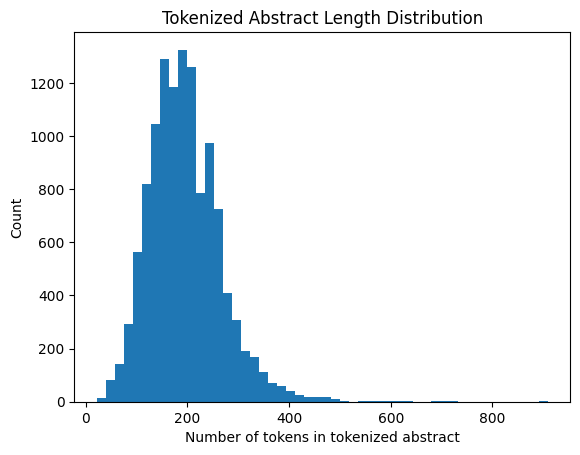

90th percentile: 282.0
95th percentile: 319.0


In [8]:
print("Number of abstract: ", len(tokenized_X_LSTM))

tokenized_lengths = [len(tokens) for tokens in tokenized_X_LSTM]
print("Average size of tokenized abstracts: ", round(sum(tokenized_lengths) / len(tokenized_lengths)))

plt.hist(tokenized_lengths, bins=50)
plt.xlabel("Number of tokens in tokenized abstract")
plt.ylabel("Count")
plt.title("Tokenized Abstract Length Distribution")
plt.show()

print("90th percentile:", np.percentile(tokenized_lengths, 90))
print("95th percentile:", np.percentile(tokenized_lengths, 95))

In [9]:
# explore the vocabulary created in the pre-processing pipeline
top_20 = word_frequency.most_common(20)
print("20 most common:")

for word, count in top_20: 
    print(f"\t{word}: {count}")

least_10 = word_frequency.most_common()[:-11:-1]
print("10 least common:")
for word, count in least_10: 
    print(f"\t{word}: {count}")

20 most common:
	the: 137659
	of: 94404
	and: 83693
	in: 56425
	to: 51202
	a: 42398
	for: 24482
	is: 23694
	with: 22828
	that: 18285
	this: 15408
	on: 15254
	as: 14479
	by: 13685
	are: 13271
	were: 11397
	was: 11316
	we: 10254
	an: 10054
	from: 9392
10 least common:
	georegistration: 1
	self-calibration,: 1
	geo-accurate: 1
	non-a: 1
	anti-amyloid-beta: 1
	crelated: 1
	communitylevel: 1
	dmpp.: 1
	n-related: 1
	non-disruptive: 1


Domain (YL1) class counts: 
 y1
4    2107
2    1959
3    1925
6    1728
5    1617
0    1499
1    1132
Name: count, dtype: int64


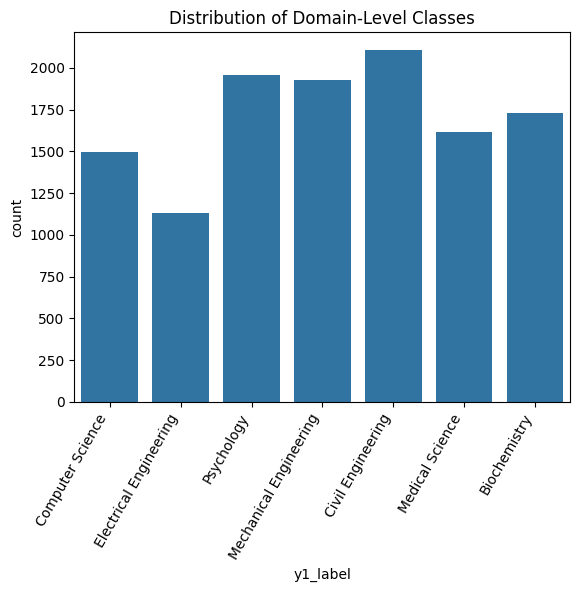

In [10]:
# explore the labels y1 & y2
y_vals = pd.DataFrame({'y1':y1, 'y2':y2})
y_vals['y1_label'] = y_vals['y1'].map(labels)

print("Domain (YL1) class counts: \n", y_vals['y1'].value_counts())

sns.countplot(x='y1_label', data=y_vals, order=list(labels.values()))
plt.xticks(rotation=60, ha='right')
plt.title("Distribution of Domain-Level Classes")
plt.show()

In [ ]:
#bert_model = AutoModel.from_pretrained('bert-base-uncased')

#with torch.no_grad(): 
#    outputs = bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
# embeddings = outputs.last_hidden_state
# cls_embeddings = embeddings[:, 0, :]

## Data Loader - LSTM

In [11]:
# convert labels to tensors
y1_tensor = torch.tensor(y1, dtype=torch.long)
y2_tensor = torch.tensor(y2, dtype=torch.long)

# define batch size
BATCH_SIZE = 32

# create dataset for LSTM
lstm_dataset = TensorDataset(X_tensor, y1_tensor, y2_tensor)

# split into train, validation, and test sets (here 70%, 15%, 15%)
train_size = int(0.7 * len(lstm_dataset))
val_size = int(0.15 * len(lstm_dataset))
test_size = len(lstm_dataset) - train_size - val_size

# use a generator for reproducibility
generator = torch.Generator().manual_seed(42)
lstm_train_dataset, lstm_val_dataset, lstm_test_dataset = random_split(lstm_dataset, [train_size, val_size, test_size], generator=generator)

# create DataLoaders
lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
lstm_val_loader = DataLoader(lstm_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
lstm_test_loader = DataLoader(lstm_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"LSTM DataLoaders created: train ({len(lstm_train_loader)} batches), val ({len(lstm_val_loader)} batches), test ({len(lstm_test_loader)} batches)")

LSTM DataLoaders created: train (262 batches), val (57 batches), test (57 batches)


## Data Loader - BERT

In [12]:
# create full dataset for BERT
bert_dataset = TensorDataset(input_ids, attention_mask, y1_tensor, y2_tensor)

# split using the same generator to attempt similar distribution (though indices might differ if not careful; this is standard practice)
bert_train_dataset, bert_val_dataset, bert_test_dataset = random_split(bert_dataset, [train_size, val_size, test_size], generator=generator)

# create DataLoaders
bert_train_loader = DataLoader(bert_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
bert_val_loader = DataLoader(bert_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
bert_test_loader = DataLoader(bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"BERT DataLoaders created: train ({len(bert_train_loader)} batches), val ({len(bert_val_loader)} batches), test ({len(bert_test_loader)} batches)")

BERT DataLoaders created: train (262 batches), val (57 batches), test (57 batches)


# Task 2: Implement LSTM and BERT models

### LSTM Models (Hyperparameter Tuning)

No saved model found at saved_models/lstm_subdomain_lr_0.100_20.pkl
No saved model found at saved_models/lstm_subdomain_lr_0.050_20.pkl
Model loaded from saved_models/lstm_subdomain_lr_0.010_20.pkl
No saved model found at saved_models/lstm_subdomain_lr_0.005_20.pkl
No saved model found at saved_models/lstm_subdomain_lr_0.001_20.pkl


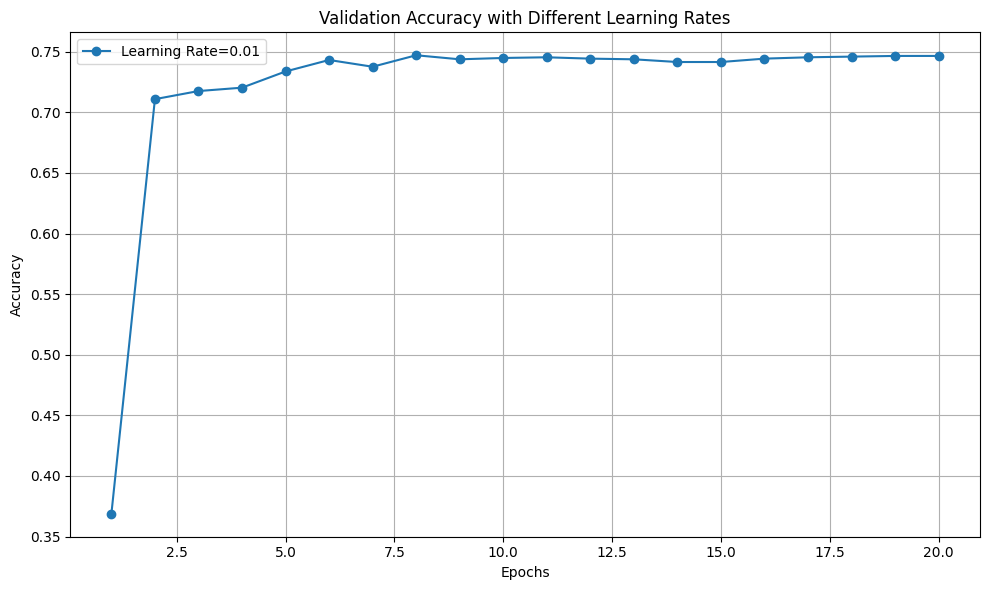

In [13]:
plt.figure(figsize=(10, 6))
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]

for lr in learning_rates:
    model = slm.load_model(f"lstm_subdomain_lr_{lr:.3f}_20.pkl")
    
    if model is None:
        continue
    
    epochs = range(1, len(model.val_losses) + 1)
    summary(model)
    plt.plot(epochs, model.val_accuracies, marker='o', label=f'Learning Rate={lr}')

plt.title('Validation Accuracy with Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

No saved model found at saved_models/lstm_domain_lr_0.100_20.pkl
No saved model found at saved_models/lstm_domain_lr_0.050_20.pkl
Model loaded from saved_models/lstm_domain_lr_0.010_20.pkl
No saved model found at saved_models/lstm_domain_lr_0.005_20.pkl
No saved model found at saved_models/lstm_domain_lr_0.001_20.pkl


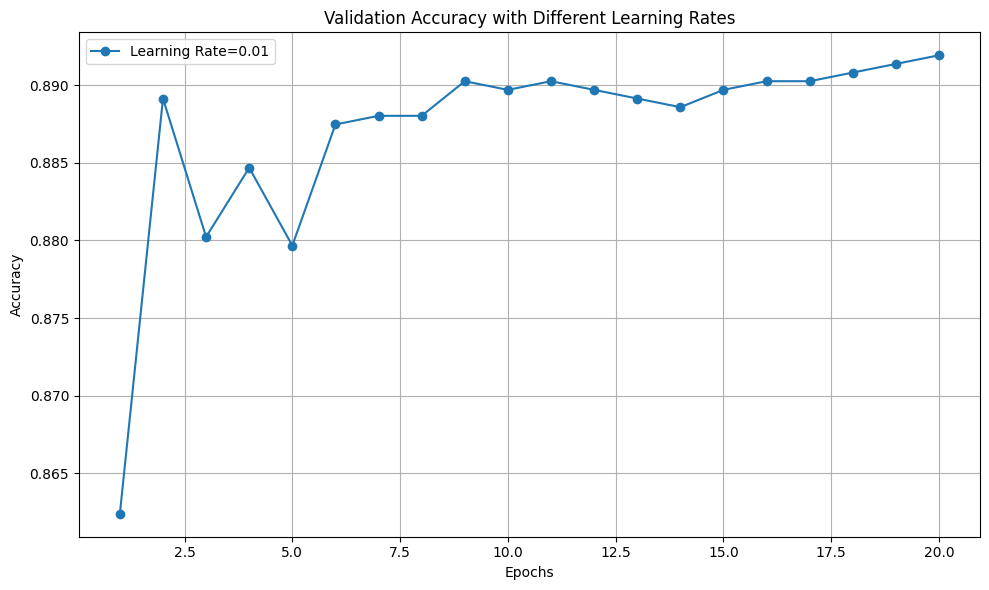

In [14]:
plt.figure(figsize=(10, 6))
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]

for lr in learning_rates:
    model = slm.load_model(f"lstm_domain_lr_{lr:.3f}_20.pkl")
    if model is None:
        continue
    epochs = range(1, len(model.val_losses) + 1)
    summary(model)
    plt.plot(epochs, model.val_accuracies, marker='o', label=f'Learning Rate={lr}')

plt.title('Validation Accuracy with Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

### BERT Models (Hyperparameter Tuning)

No saved model found at saved_models/bert_subdomain_lr_0.100_5.pkl
No saved model found at saved_models/bert_subdomain_lr_0.050_5.pkl
No saved model found at saved_models/bert_subdomain_lr_0.010_5.pkl
No saved model found at saved_models/bert_subdomain_lr_0.005_5.pkl
No saved model found at saved_models/bert_subdomain_lr_0.001_5.pkl


/var/folders/sn/rf4nktlx2xz1nx870f1tb2fc0000gn/T/ipykernel_8336/2371352169.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


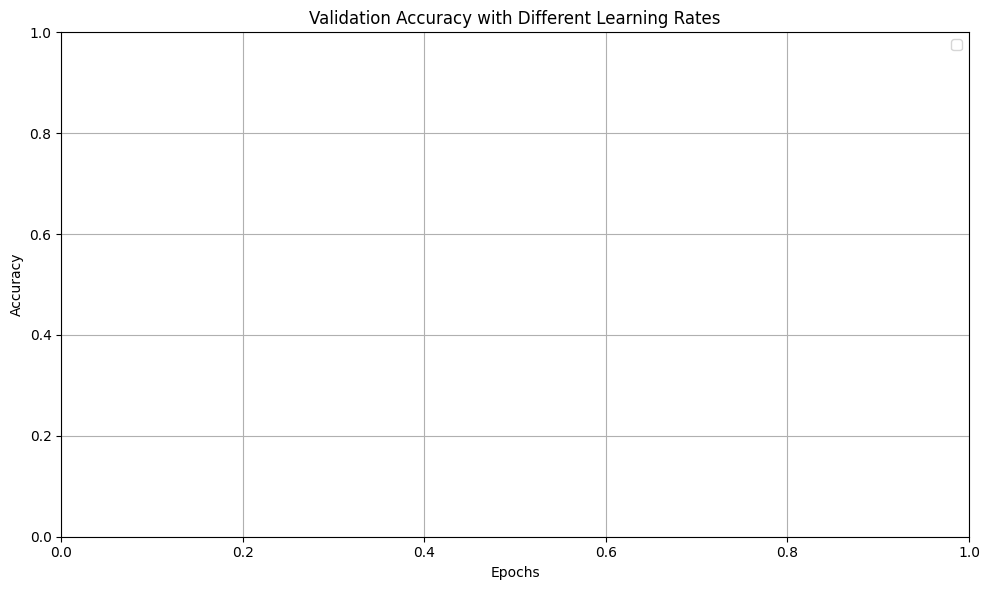

In [18]:
plt.figure(figsize=(10, 6))
learning_rates = [0.00001, 0.00002, 0.00005]

for lr in learning_rates:
    model = slm.load_model(f"bert_subdomain_lr_{lr}.pkl")
    
    if model is None:
        continue
    
    epochs = range(1, len(model.val_losses) + 1)
    summary(model)
    plt.plot(epochs, model.val_accuracies, marker='o', label=f'Learning Rate={lr}')

plt.title('Validation Accuracy with Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

No saved model found at saved_models/bert_domain_lr_0.100_5.pkl
No saved model found at saved_models/bert_domain_lr_0.050_5.pkl
No saved model found at saved_models/bert_domain_lr_0.010_5.pkl
No saved model found at saved_models/bert_domain_lr_0.005_5.pkl
No saved model found at saved_models/bert_domain_lr_0.001_5.pkl


/var/folders/sn/rf4nktlx2xz1nx870f1tb2fc0000gn/T/ipykernel_8336/3645307901.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


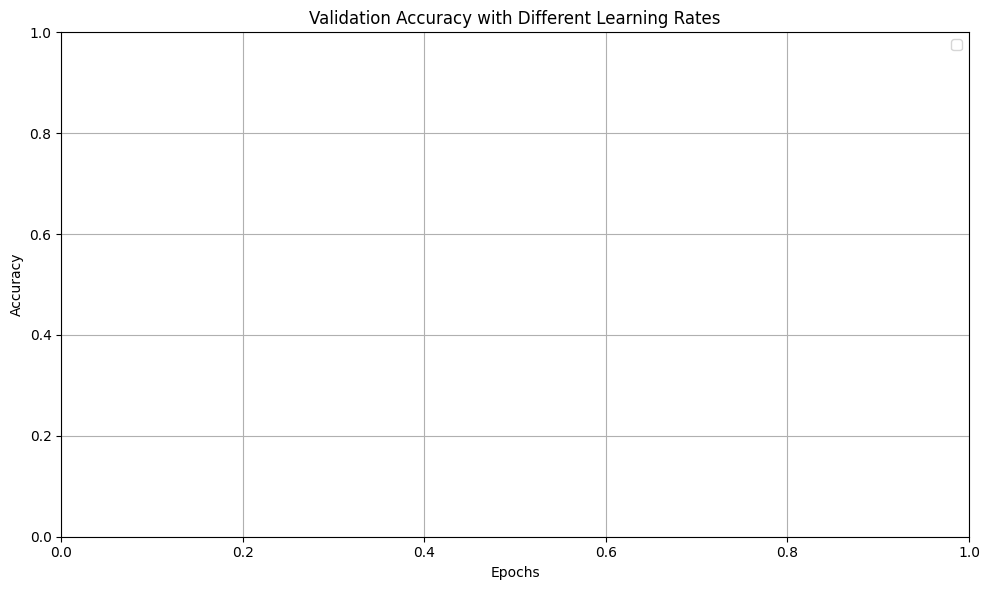

In [19]:
plt.figure(figsize=(10, 6))
learning_rates = [0.00001, 0.00002, 0.00005]

for lr in learning_rates:
    model = slm.load_model(f"bert_domain_lr_{lr}.pkl")
    if model is None:
        continue
    epochs = range(1, len(model.val_losses) + 1)
    summary(model)
    plt.plot(epochs, model.val_accuracies, marker='o', label=f'Learning Rate={lr}')

plt.title('Validation Accuracy with Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

# Task 3: Running Experiments

### (1) Comparison of the LSTM & BERT Models

In [22]:
LSTM_BEST_LR = 0.01
BERT_BEST_LR = 0 # change this (after hyperparameter tuning)

lstm_domain = slm.load_model(f"lstm_domain_lr_{LSTM_BEST_LR:.3f}_20.pkl")
lstm_subdomain = slm.load_model(f"lstm_subdomain_lr_{LSTM_BEST_LR:.3f}_20.pkl")

bert_domain = slm.load_model(f"bert_domain_lr_{BERT_BEST_LR}_5.pkl")
bert_subdomain = slm.load_model(f"bert_subdomain_lr_{BERT_BEST_LR}_5.pkl")

results = {
    "Model": ["LSTM", "BERT"],
    "Domain Test Accuracy": [lstm_domain.test_accuracies[-1], bert_domain.test_accuracies[-1]],
    "Subdomain Test Accuracy": [lstm_subdomain.test_accuracies[-1], bert_subdomain.test_accuracies[-1]]
}

print(pd.DataFrame(results))

Model loaded from saved_models/lstm_domain_lr_0.010_20.pkl
Model loaded from saved_models/lstm_subdomain_lr_0.010_20.pkl
  Model  Domain Test Accuracy  Subdomain Test Accuracy
0  LSTM              0.873608                 0.785078
1  BERT              0.000000                 0.000000


### (2) Attention Matrix

#### (a) Words & Class Tokens

In [23]:
# setting our device!
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# arbitrary choice (5 & 5)
transformer_block = 5
attention_head = 5

bert_domain.eval() # is this necessary?

batch = next(iter(bert_test_loader)) # first batch
correctly_predicted_documents = []
incorrectly_predicted_documents = []

# find correctly & incorrectly predicted documents
with torch.no_grad():
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device) # since domain

    outputs = bert_domain(input_ids, attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)

    # iterating through the predictions to find documents
    for i in range(len(preds)):
        document = {
            "input_ids": input_ids[i].unsqueeze(0), # unsqueeze(0) for BERT
            "attention_mask": attention_mask[i].unsqueeze(0),
            "label": labels[i].item(),
            "pred": preds[i].item()
        }

        if preds[i] == labels[i]:
            correctly_predicted_documents.append(document)
        else:
            incorrectly_predicted_documents.append(document)

correctly_predicted_document = correctly_predicted_documents[0]
incorrectly_predicted_document = incorrectly_predicted_documents[0]

with torch.no_grad():
    correct_outputs = bert_domain(
        correctly_predicted_document["input_ids"].to(device),
        correctly_predicted_document["attention_mask"].to(device),
        output_attentions = True
    )

    incorrect_outputs = bert_domain(
        incorrectly_predicted_document["input_ids"].to(device),
        incorrectly_predicted_document["attention_mask"].to(device),
        output_attentions = True
    )

correct_attention_matrix = correct_outputs.attentions[transformer_block][0][attention_head]
incorrect_attention_matrix = incorrect_outputs.attentions[transformer_block][0][attention_head]

CLS_correct = correct_attention_matrix[0].numpy() # 0: for CLS, might need a .cpu() if on a GPU
CLS_incorrect = incorrect_attention_matrix[0].numpy() # same here!

correct_tokens = bert_tokenizer.convert_ids_to_tokens(correctly_predicted_document["input_ids"][0].tolist())
incorrect_tokens = bert_tokenizer.convert_ids_to_tokens(incorrectly_predicted_document["input_ids"][0].tolist())

AttributeError: 'NoneType' object has no attribute 'bert'

#### (b) Plot the Matrix Between the Words and the Class Tokens

In [ ]:
# pair the tokens w/ their corresponding attention weight
correct_pairs = []
for i in range(len(correct_tokens)):
    correct_pairs.append((
        correct_tokens[i], CLS_correct[i]
    ))

incorrect_pairs = []
for i in range(len(incorrect_tokens)):
    incorrect_pairs.append((
        incorrect_tokens[i], CLS_incorrect[i]
    ))

# ascending order
correct_pairs.sort(key = lambda tup: tup[1], reverse=True)
incorrect_pairs.sort(key = lambda tup: tup[1], reverse=True)

# 25 top tokens
top_correct_tokens = [pair[0] for pair in correct_pairs[:25]]
top_correct_weight = [pair[1] for pair in correct_pairs[:25]]

top_incorrect_tokens = [pair[0] for pair in incorrect_pairs[:25]]
top_incorrect_weight = [pair[1] for pair in incorrect_pairs[:25]]

# plot for correctly predicted document
plt.figure(figsize=(20, 5))
plt.bar(range(len(top_correct_tokens)), top_correct_weight)
plt.xticks(range(len(top_correct_tokens)), top_correct_tokens, rotation=90)
plt.title("Top 25 tokens attended by [CLS] (correctly predicted document)")
plt.show()

# plot for incorrectly predicted document
plt.figure(figsize=(20, 5))
plt.bar(range(len(top_incorrect_tokens)), top_incorrect_weight)
plt.xticks(range(len(top_incorrect_tokens)), top_incorrect_tokens, rotation=90)
plt.title("Top 25 tokens attended by [CLS] (incorrectly predicted document)")
plt.show()